This notebook is part of my [Python data science curriculum](http://www.terran.us/articles/python_curriculum.html)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import altair as alt
alt.renderers.enable("notebook")

RendererRegistry.enable('notebook')

# K-Means

For k-means clustering we have a choice between scipy and sklearn.

In [2]:
np.random.seed(6)
data = pd.DataFrame({
    'x':stats.norm(loc=2).rvs(50),
    'y':stats.norm(loc=1).rvs(50),
    'class':0}
).append(pd.DataFrame({
    'x':stats.norm(loc=-2).rvs(50),
    'y':stats.norm(loc=-1).rvs(50),
    'class':1}
))

data.head().append(data.tail())

,x,y,class
0,1.688216,1.358771,0
1,2.729004,2.073681,0
2,2.217821,0.624495,0
3,1.100908,1.396368,0
4,-0.486781,0.528554,0
45,-1.108347,-1.448566,1
46,-2.984728,-2.449928,1
47,-2.210627,-3.706931,1
48,-1.333842,0.115694,1
49,-2.796248,-0.205897,1


## Scipy Implementation 1

In [3]:
import scipy.cluster as cluster

In [4]:
clresult=cluster.vq.kmeans(data[['x','y']],2)
clresult

(array([[-2.24546324, -0.89634332],
        [ 2.09757364,  1.18613004]]), 1.1857185068108236)

That's the cluster centroids.  Apparently if we want to actually assign observations, we have to do it manually?

In [5]:
centroids=pd.DataFrame(clresult[0],columns=['x','y'])

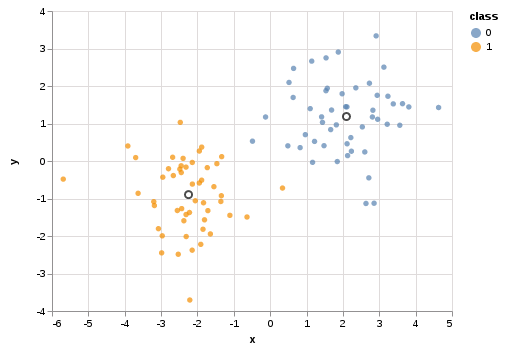

In [6]:
alt.Chart(data).mark_circle().encode(
    x='x',
    y='y',
    color='class:N'
) + alt.Chart(centroids).mark_point(color='black',size=50).encode(
    x='x',
    y='y')

## Scipy Implementation 2

There is a _second_ implementation in scipy, which does assign clusters:

In [7]:
clresult2=cluster.vq.kmeans2(data[['x','y']],2)
clresult2

(array([[ 2.06240285,  1.14797777],
        [-2.29715318, -0.89984052]]),
 array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32))

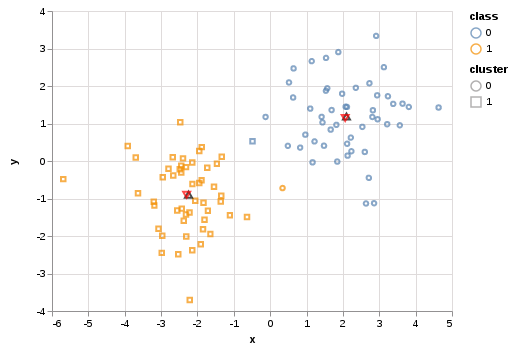

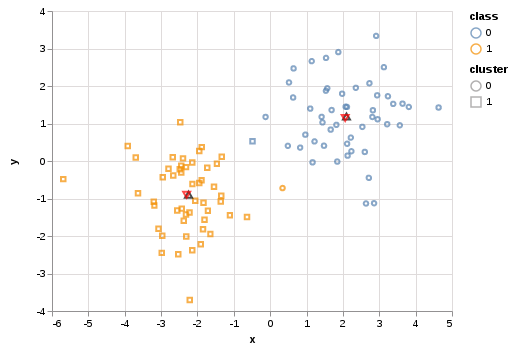

In [8]:
centroids2=pd.DataFrame(clresult2[0],columns=['x','y'])
alt.Chart(data.assign(cluster=clresult2[1])).mark_point(size=20).encode(
    x='x',
    y='y',
    color='class:N',
    shape='cluster:N'
) + alt.Chart(centroids).mark_point(color='black',size=50,shape='triangle-up').encode(
    x='x',
    y='y'
) + alt.Chart(centroids2).mark_point(color='red',size=50,shape='triangle-down').encode(
    x='x',
    y='y')

For some sets of random inputs, it also sometimes produced a different result, although not very different.  The random seed in this notebook was specifically chosen to illustrate this difference, as most don't.  kmeans2 is nondeterministic: sometimes it produces a result which matches kmeans, and sometimes it produces the other result.

## SKLearn

In [9]:
import sklearn.cluster as skcluster # "cluster" was already used for the scipy library

In [10]:
skresult=skcluster.KMeans(n_clusters=2).fit(data[['x','y']])

In [11]:
skresult.cluster_centers_

array([[-2.29715318, -0.89984052],
       [ 2.06240285,  1.14797777]])

These centroids are identical to the first scipy implementation:

In [12]:
clresult

(array([[-2.24546324, -0.89634332],
        [ 2.09757364,  1.18613004]]), 1.1857185068108236)

sklearn also gives the cluster assignments:

In [13]:
skresult.labels_

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

## K-Means Conclusions

The first scipy implementation - `scipy.cluster.vq.kmeans` - is unacceptable because it doesn't actually give you the cluster assignments of the points.  Obviously you _could_ calculate that yourself, but why would you want to bother?  The other scipy implementation, `scipy.cluster.vq.kmeans2` produces nondeterministic centroids on even very simple 2d data, which does not inspire confidence.

Based on that, I favor the scikit implementation, `sklearn.cluster.KMeans`.

# Hierarchical

Unlike kmeans, hierarchical clustering with the correct linkage should be able to reconstruct nonlinear manifolds.

In [14]:
np.random.seed(1)
# This separation is chosen to be fairly easy but not trivial
data2 = pd.DataFrame({
    'r':stats.norm(loc=1.5,scale=0.35).rvs(300),
    'theta':stats.uniform(0,2*np.pi).rvs(300),
    'class':0}
).append(pd.DataFrame({
    'r':stats.norm(loc=4,scale=0.5).rvs(300),
    'theta':stats.uniform(0,2*np.pi).rvs(300),
    'class':1}
))

In [15]:
data2['x']=data2['r']*np.cos(data2['theta'])
data2['y']=data2['r']*np.sin(data2['theta'])
data2.head()

,r,theta,class,x,y
0,2.068521,2.776566,0,-1.932235,0.738408
1,1.285885,3.654159,0,-1.120635,-0.630618
2,1.315140,6.218793,0,1.312414,-0.084626
3,1.124461,1.281181,0,0.321128,1.077631
4,1.802893,1.556552,0,0.025681,1.802710


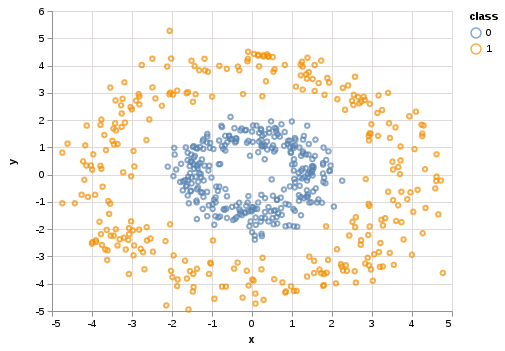

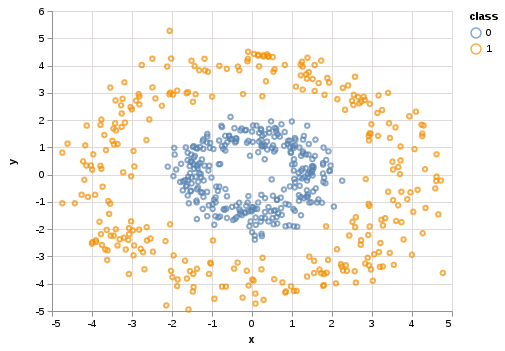

In [16]:
alt.Chart(data2).mark_point(size=20).encode(
    x='x',
    y='y',
    color='class:N')

## Scipy

In [17]:
# For nonlinear manifolds single linkage is the only way to go
hier1 = cluster.hierarchy.single(data2[['x','y']])

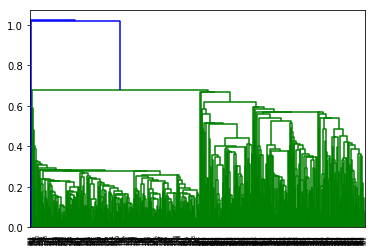

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
cluster.hierarchy.dendrogram(hier1)
plt.show()

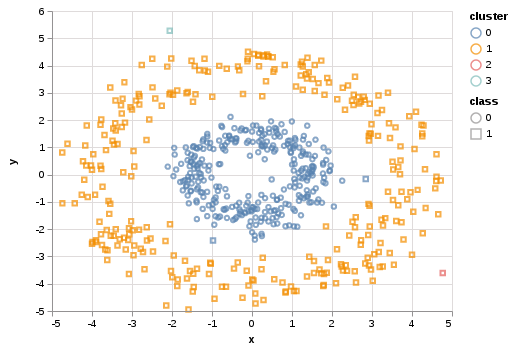

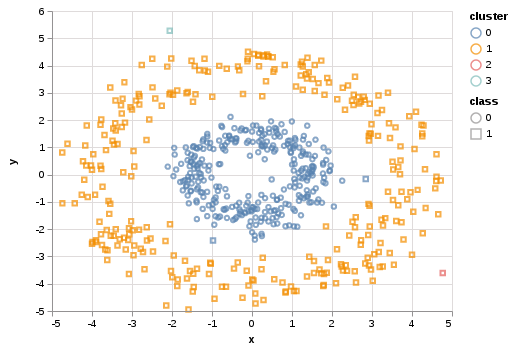

In [19]:
clusters1 = cluster.hierarchy.cut_tree(hier1,4)
alt.Chart(data2.assign(cluster=clusters1)).mark_point(size=20).encode(
    x='x',
    y='y',
    shape='class:N',
    color='cluster:N')

## sklearn

In [20]:
# The documentation says single linkage is supported
# https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering
# but it's not implemented in 0.19, the version I have in Anaconda 5.2.0:
try:
    hier2=skcluster.AgglomerativeClustering(linkage='single').fit(data[['x','y']])
except Exception as ex:
    print(repr(ex))

ValueError("Unknown linkage type single.Valid options are dict_keys(['ward', 'complete', 'average'])",)


No dendrogram plot is offered.

In [21]:
# If you have a later sklearn, maybe this will work for you:

#alt.Chart(data2.assign(cluster=hier2.labels_)).mark_point(size=20).encode(
#    x='x',
#    y='y',
#    shape='class:N',
#    color='cluster:N')

### Conclusions

sklearn falls short in every way here.  Use scipy.